In [11]:
from pytfa.io.json import load_json_model
from skimpy.io.yaml import  load_yaml_model
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations, load_fluxes
from skimpy.core.parameters import ParameterValues
from skimpy.utils.namespace import *
from skimpy.core.modifiers import *
from skimpy.io.yaml import load_yaml_model
from skimpy.core.reactor import Reactor
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations, load_fluxes
from skimpy.viz.plotting import timetrace_plot
from pytfa.io.json import load_json_model
from skimpy.io.yaml import load_yaml_model
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations
from skimpy.core.parameters import load_parameter_population
from skimpy.simulations.reactor import make_batch_reactor
from skimpy.core.solution import ODESolutionPopulation
from skimpy.utils.namespace import *
from skimpy.viz.escher import animate_fluxes, plot_fluxes
import copy
from skimpy.io.yaml import export_to_yaml
from skimpy.analysis.ode.utils import make_flux_fun

import pandas as pd
import numpy as np

#import seaborn as sns
import skimpy
import time
import matplotlib.pyplot as plt
import itertools
import matplotlib
import sys
sys.path.insert(1, '../functions/')

# benchmark functions
import simulation_functions as sf
import scenarios as sc
import visualizations as vis
import noise as noise
import comb_sampling as cs

#ML methods
from sklearn import svm
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import  AdaBoostRegressor
from scipy.stats import linregress

from skopt import BayesSearchCV
import seaborn as sns
from scipy.stats import entropy

In [12]:
a=time.time()
def find_set_designs(comb_space,tcart,enz_names):
    """finds the training or test set designs in the combinatorial space
    Number of features has to be given
    - combinatorial space
    - cart of either the training scenario or the test set
    - enzyme names"""
    temp=0
    tset = pd.DataFrame()
    for design in tcart:
        sub=comb_space
        sub=sub.loc[sub['vmax_forward_Enzyme_A']==design[0]]
        sub=sub.loc[sub['vmax_forward_Enzyme_B']==design[1]]
        sub=sub.loc[sub['vmax_forward_Enzyme_C']==design[2]]
        sub=sub.loc[sub['vmax_forward_Enzyme_D']==design[3]]
        sub=sub.loc[sub['vmax_forward_Enzyme_E']==design[4]]
        sub=sub.loc[sub['vmax_forward_Enzyme_F']==design[5]]
        sub=sub.loc[sub['vmax_forward_Enzyme_G']==design[6]]
        tset=pd.concat([tset,sub])
    return tset,tcart


def check_if_unique(train_x):
    my_list=[]
    number_of_elements=0
    indices_to_remove=[]
    """Check whether designs are all unique in the training data"""
    for i in range(np.shape(train_x)[0]):
        my_list.append(tuple(train_x.iloc[i,:]))
    for i in range(len(my_list)):
        for j in range(len(my_list)):
            if i!=j:
                if my_list[i]==my_list[j]:
                    number_of_elements+=1
                    indices_to_remove.append(i)
    return indices_to_remove,number_of_elements
                    



def add_training_data(training_df,params):
    """Adds data to the already existing DBTL training data"""
    params2=params 
    #correct sampling strategy from four options
    if params['sampling_strategy']=="equal":
        cyc_designs,cyc_cart=sc.scenario1(params['perturb_range'],params['N_designs'],params['enz_names'])
        training_cyc,training_cart=find_set_designs(params['combinatorial_space'],cyc_cart,params['enz_names']) 
    elif params['sampling_strategy']=="radical":
        cyc_designs,cyc_cart=sc.scenario2(params['perturb_range'],params['N_designs'],params['enz_names'])
        training_cyc,training_cart=find_set_designs(params['combinatorial_space'],cyc_cart,params['enz_names']) 
    elif params['sampling_strategy']=="non-radical":
        cyc_designs,cyc_cart=sc.scenario3(params['perturb_range'],params['N_designs'],params['enz_names'])
        training_cyc,training_cart=find_set_designs(params['combinatorial_space'],cyc_cart,params['enz_names']) 
    elif params['sampling_strategy']=="manual":
        cyc_designs,cyc_cart=sc.manual_scenario(params['perturb_range'],params['N_designs'],
                                                params['probability_matrix'],params['enz_names'])
        training_cyc,training_cart=find_set_designs(params['combinatorial_space'],cyc_cart,params['enz_names']) 
    
    #add noise
    if params['noise_model']=="homoschedastic":
        noise_G=noise.add_homoschedastic_noise(training_cyc['Enzyme_G'],params['noise_percentage'])
    elif params['noise_model']=="heteroschedastic":
        noise_G=noise.add_heteroschedastic_noise(training_cyc['Enzyme_G'],params['noise_percentage'])
    
    training_cyc['Enzyme_G']=noise_G
    dfs=[training_df,training_cyc]
    training_df=pd.concat(dfs)
    
    #Check whether all items are unique, if not, add data for scenario
    remove_ind,number_of_elements=check_if_unique(training_df)
    while number_of_elements!=0:
        training_df=training_df.drop(training_df.index[remove_ind])
        params2['N_designs']=number_of_elements
        cyc_designs,cyc_cart=sc.manual_scenario(params2['perturb_range'],params2['N_designs'],
                                                params2['probability_matrix'],params2['enz_names'])
        training_cyc,training_cart=find_set_designs(params['combinatorial_space'],cyc_cart,params['enz_names']) 
            #add noise
        if params2['noise_model']=="homoschedastic":
            noise_G=noise.add_homoschedastic_noise(training_cyc['Enzyme_G'],params2['noise_percentage'])
        elif params2['noise_model']=="heteroschedastic":
            noise_G=noise.add_heteroschedastic_noise(training_cyc['Enzyme_G'],params2['noise_percentage'])
        
        training_cyc['Enzyme_G']=noise_G
        dfs=[training_df,training_cyc]
        training_df=pd.concat(dfs)
        remove_ind,number_of_elements=check_if_unique(training_df)
    
    #training and test split
    train_x=training_df[enz_names]
    train_y=training_df['Enzyme_G']
    return train_x,train_y,training_df


def train_model(params,train_x,train_y):
    if params['ML_model']=="GradientBoostingRegressor":
        #random forest 
        regr_gbr = BayesSearchCV(
        GradientBoostingRegressor(),
        {
            "min_samples_split":(2,3,4,5,6,7,8),
            "min_samples_leaf":(2,3,4,5,6,7,8),
            "max_depth": (1,2,3,4,5,7,8),
            "learning_rate":(0.00001,0.0001,0.001,0.01,0.1,0.2,0.3),
        },
        n_iter=20,
        cv=5)
        regr_gbr.fit(train_x,train_y)
    return regr_gbr

def get_probability_matrix(prediction,params,plotting=False):
    """Given the predictive model, use the AUC for each promoter strength and enzyme 
    as a probability distribution to sample from
    
    INPUT:
    --> prediction: prediction of the full combinatorial space for your model
    --> params"""
    comb_space=params['combinatorial_space']
    pred_comb_space=comb_space.copy()
    pred_comb_space['Enzyme_G']=prediction.copy()
    threshold,matrix_pred,remaining_designs_pred=cs.scan_combinatorial_space(pred_comb_space,
                                                                             params['perturb_range'],
                                                                             params['enz_names'],0.005)
    
    enz_numbers,sorted_entropies,probability_matrix=cs.get_feature_importance(matrix_pred,pred_comb_space)
    if plotting==True:
        enzyme_x=input("Enzyme number:")
        enz=int(enzyme_x)
        A025=[]
        A05=[]
        A1=[]
        A15=[]
        A2=[]
        A4=[]
        for i in range(np.shape(matrix_pred)[2]):
            A025.append(matrix_pred[0,enz,i])
            A05.append(matrix_pred[1,enz,i])
            A1.append(matrix_pred[2,enz,i])
            A15.append(matrix_pred[3,enz,i])
            A2.append(matrix_pred[4,enz,i])
            A4.append(matrix_pred[5,enz,i])    
        plt.plot(threshold,A025,label="0.25",linewidth=2)
        plt.plot(threshold,A05,label="0.5",linewidth=2)
        plt.plot(threshold,A1,label="1",linewidth=2)
        plt.plot(threshold,A15,label="1.5",linewidth=2)
        plt.plot(threshold,A2,label="2",linewidth=2)
        plt.plot(threshold,A4,label="4",linewidth=2)
        #plt.plot(threshold,remaining_designs,c="black",label="Remaining designs space",linewidth=3,linestyle="--")
        plt.axhline(1/6,c="black",linestyle="--")
        plt.legend(title="Promoter strength",bbox_to_anchor=(1.,1))
        plt.ylabel("Frequency")
        plt.xlabel("Relative flux increase")
        plt.title(str(params['enz_names'][enz]))
        plt.show()
    return enz_numbers,sorted_entropies,probability_matrix,matrix_pred


def DBTL(training_df,params,plotting=False):
    """Wrapper function for the DBTL cycle simulation
    Input: training dataframe, parameters
    Output:
    training_df: the training dataframe for the next cycle
    enz_numbers: ordered enz numbers based on feature importance
    sorted_entropies: order entropies of the enz_numbers
    probability matrix: sampling distribution for the next cycle
    top100: intersection value of the top 100 prediction
    top100_designs: the designs in the predicted top 100 (to check when best design is found
    score: r2 value"""
    train_x,train_y,training_df=add_training_data(training_df, params)
    GBR=train_model(params,train_x,train_y)
    prediction=GBR.predict(test_x)

    #evaluate
    slope, intercept, r_value, p_value, std_err = linregress(test_y,prediction)
    score=r_value**2
    top100=np.argsort(test_y)[::-1][0:100]
    top100_pred=np.argsort(prediction)[::-1][0:100]
    top100=len(np.intersect1d(top100,top100_pred))
    top100_designs=top100_pred
    print(score,top100)
    #prepare next cycle
    enz_numbers,sorted_entropies,probability_matrix,matrix_pred=get_probability_matrix(prediction,params,plotting=plotting)  
    return training_df,probability_matrix,top100,top100_designs,score,prediction

def find_top1_design(top100_designs,params):
    """finds whether the top design is in the predicted top 100, returns a binary (0 is nope, 1 is yep)"""
    comb_space=params['combinatorial_space']
    binary=0
    x=list(np.argsort(comb_space['Enzyme_G'])[::-1])
    top_ind=x[0]
    print(x[0])
    y=np.argwhere(top100_designs==top_ind)
    if len(y)==1:
        binary=1
    else:
        binary=0
    
    return binary,y


def cost_model(N_designs,fixed_costs):
    """shows the time and money for each DBTL cycle
    Input: 
    number of designs
    fixed costs: costs per week to run a lab
    """
    time=0
    money=0
    if N_designs<24:
        time=6.8 #number of weeks
        money=1813.33*N_designs
    elif N_designs>=24 and N_designs<=96:
        time=9.6 
        money=640*N_designs
    elif N_designs>96 and N_designs<384:
        time=14
        money=233.33*N_designs
    else:
        time=17
        money=70.833*N_designs
    time_money=time*fixed_costs
    money=money+time_money
    return money,time   

In [13]:
#Load simulations
comb_space=pd.read_csv("../data/combinatorial_space/combinatorial_space_pathway_A.csv")

#enzyme names and perturbation range
enz_names=["vmax_forward_Enzyme_A","vmax_forward_Enzyme_B","vmax_forward_Enzyme_C","vmax_forward_Enzyme_D",
           "vmax_forward_Enzyme_E","vmax_forward_Enzyme_F","vmax_forward_Enzyme_G"] #'vmax_forward_LDH_D',
perturb_range=[0.25,0.5,1,1.5,2,4]
designs,cart=sf.generate_perturbation_scheme(enz_names,perturb_range)
N_designs=50
noise_percentage=0.04


params={
    "sampling_strategy":"equal", #equal, radical, non-radical, manual (requires probability matrix)
    "combinatorial_space": comb_space,
    "noise_model":"homoschedastic",
    "noise_percentage":0.15,
    "perturb_range":perturb_range,
    "N_designs":None,
    "ML_model": "GradientBoostingRegressor",
    "probability_matrix":None,
    "enz_names":enz_names}

test_x=comb_space[enz_names]
test_y=comb_space['Enzyme_G']

0.8901913974875322 9


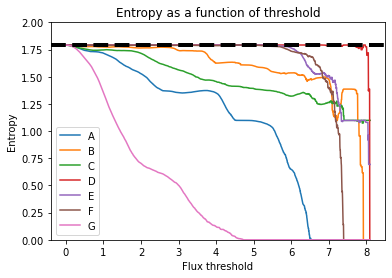

In [14]:
#DBTL 1
a=time.time()

df_init=pd.DataFrame()
params['N_designs']=200
training_df,probability_matrix1,top100_1,top_design_1,score_1,prediction=DBTL(df_init,params,plotting=False)
feature_importance1=cs.feature_entropies(prediction,params,plotting=True)
#mu_random_entropy,si_random_entropy=cs.reference_noise_model(prediction,params, 2)
#sig_1=cs.get_significance_statement(feature_importance1,mu_random_entropy,si_random_entropy,std=3)



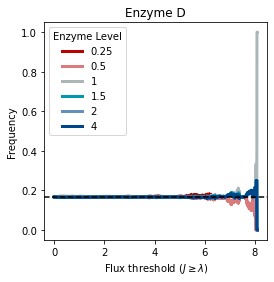

In [17]:
def get_probability_matrix(prediction,params,plotting=False):
    """Given the predictive model, use the AUC for each promoter strength and enzyme 
    as a probability distribution to sample from
    
    INPUT:
    --> prediction: prediction of the full combinatorial space for your model
    --> params"""
    comb_space=params['combinatorial_space']
    pred_comb_space=comb_space.copy()
    pred_comb_space['Enzyme_G']=prediction.copy()
    threshold,matrix_pred,remaining_designs_pred=cs.scan_combinatorial_space(pred_comb_space,
                                                                             params['perturb_range'],
                                                                             params['enz_names'],0.002)
    
    enz_numbers,sorted_entropies,probability_matrix=cs.get_feature_importance(matrix_pred,pred_comb_space)
    if plotting==True:
        enzyme_x=input("Enzyme number:")
        enz=int(enzyme_x)
        title=str(params['enz_names'][enz])
        title=title.split("_")
        title=title[2]+" "+title[3]
        A025=[]
        A05=[]
        A1=[]
        A15=[]
        A2=[]
        A4=[]
        for i in range(np.shape(matrix_pred)[2]):
            A025.append(matrix_pred[0,enz,i])
            A05.append(matrix_pred[1,enz,i])
            A1.append(matrix_pred[2,enz,i])
            A15.append(matrix_pred[3,enz,i])
            A2.append(matrix_pred[4,enz,i])
            A4.append(matrix_pred[5,enz,i])
        
        fig,ax = plt.subplots(figsize=(4, 4))  
        plt.plot(threshold,A025,label="0.25",linewidth=3,c='#BB0103')
        plt.plot(threshold,A05,label="0.5",linewidth=3,c='#DB7A7B')
        plt.plot(threshold,A1,label="1",linewidth=3,c='#ADB6B6FF')
        plt.plot(threshold,A15,label="1.5",linewidth=3,c='#0099B4FF')
        plt.plot(threshold,A2,label="2",linewidth=3,c='#00468B99')
        plt.plot(threshold,A4,label="4",linewidth=3,c='#00468BFF')
        #plt.plot(threshold,remaining_designs,c="black",label="Remaining designs space",linewidth=3,linestyle="--")
        plt.axhline(1/6,c="black",linestyle="--")
        plt.legend(title="Enzyme Level")
        plt.ylabel("Frequency")
        plt.xlabel("Flux threshold ($J\geq\lambda$)")
        plt.title(title)
        plt.show()
    return enz_numbers,sorted_entropies,probability_matrix,matrix_pred,fig


enz_numbers,sorted_entropies,probability_matrix,matrix_pred,fig=get_probability_matrix(prediction,params,True)


In [16]:
fig.savefig("../../../Results/Benchmark paper/Figure 5/Promoter_Frequency_Enzyme_D.svg",bbox_inches="tight")

Text(0, 0.5, 'Probability')

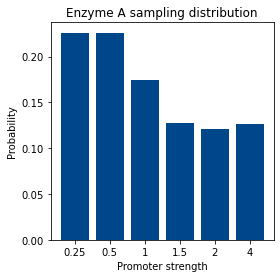

In [12]:
fig,ax=plt.subplots(figsize=(4,4))
plt.bar(["0.25","0.5","1","1.5","2","4"],probability_matrix[:,3],color='#00468BFF')
plt.xlabel("Promoter strength")
plt.title("Enzyme A sampling distribution")
plt.ylabel("Probability")
#fig.savefig("../../../Results/Benchmark paper/Figure 5/New_Distribution_Enzyne_A.svg",bbox_inches="tight")


In [90]:
a_dict[a_dict.columns[::-1]]

,Enz. G,Enz. F,Enz. E,Enz. D,Enz. C,Enz. B,Enz. A
0.25,0.814455,0.087613,0.052202,0.153147,0.019809,0.060381,0.013136
0.5,0.123238,0.125857,0.097427,0.167054,0.045995,0.114349,0.028730
1,0.031315,0.179868,0.131837,0.153804,0.119135,0.132524,0.080180
1.5,0.014917,0.194356,0.154202,0.171283,0.181943,0.164101,0.188503
2,0.011073,0.230472,0.157416,0.176322,0.273772,0.206559,0.271509
4,0.005002,0.181835,0.406917,0.178389,0.359346,0.322086,0.417941


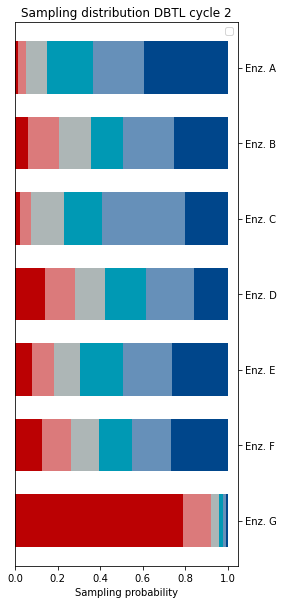

In [9]:
enzyme_names=['Enz. A',"Enz. B","Enz. C","Enz. D","Enz. E","Enz. F","Enz. G"]
rows=["0.25","0.5","1","1.5","2","4"]
my_distribution=pd.DataFrame(probability_matrix,index=rows,columns=enzyme_names)


colors= ['#BB0103','#DB7A7B','#ADB6B6FF','#0099B4FF','#00468B99','#00468BFF']
colors=colors[::-1]
a_dict=pd.DataFrame(my_distribution)
a_dict=pd.DataFrame(a_dict).sort_index()
a_dict=a_dict[a_dict.columns[::-1]]
ax=a_dict.T.plot(kind="barh",width=0.7,stacked="True",color=colors[::-1])
#ax.legend(bbox_to_anchor=(1.5,1.0),title="Promoter Strength")
ax.legend([])
ax.set_xlabel("Sampling probability")
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
plt.xticks(rotation=0)
plt.rcParams["figure.figsize"] = (4,10)
plt.title("Sampling distribution DBTL cycle 2")
plt.savefig("../../../Results/Benchmark paper/Figure 5/New_Distribution_Enzyne_A_G.svg",bbox_inches="tight")

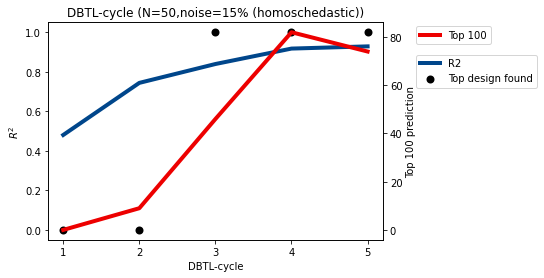

In [9]:


dbtl=[1,2,3,4,5]
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(dbtl,r2,color="#00468BFF",linewidth=4,label="R2")
ax2.plot(dbtl,top100,color="#ED0000FF",linewidth=4,label="Top 100")
ax1.scatter(dbtl,top_design_found,color="Black",linewidth=2,label="Top design found")
ax1.set_xlabel("DBTL-cycle")
ax1.set_ylabel("$R^2$")
ax2.set_ylabel('Top 100 prediction')
plt.xticks(dbtl)
plt.title("DBTL-cycle (N=50,noise=15% (homoschedastic))")
ax1.legend(loc=(1.1, 0.7))
ax2.legend(loc=(1.1, 0.9))

In [ ]:
# #DBTL2
# params['probability_matrix']=probability_matrix1
# params['sampling_strategy']="manual"
# params['N_designs']=50
# training_df,probability_matrix2,top100_2,top_design_2,score_2,prediction=DBTL(training_df,params,plotting=False)
# feature_importance2=cs.feature_entropies(prediction,params,plotting=False)
# #mu_random_entropy,si_random_entropy=cs.reference_noise_model(prediction,params, 2)
# #sig_2=cs.get_significance_statement(feature_importance2,mu_random_entropy,si_random_entropy,std=3)

# #DBTL 3
# params['probability_matrix']=probability_matrix2
# params['sampling_strategy']="manual"
# params['N_designs']=50
# training_df,probability_matrix3,top100_3,top_design_3,score_3,prediction=DBTL(training_df,params,plotting=False)
# feature_importance3=cs.feature_entropies(prediction,params,plotting=False)
# #mu_random_entropy,si_random_entropy=cs.reference_noise_model(prediction,params, 2)
# #sig_3=cs.get_significance_statement(feature_importance2,mu_random_entropy,si_random_entropy,std=3)

# # #DBTL 4
# params['probability_matrix']=probability_matrix3
# params['sampling_strategy']="manual"
# training_df,probability_matrix4,top100_4,top_design_4,score_4,prediction=DBTL(training_df,params,plotting=False)
# feature_importance4=cs.feature_entropies(prediction,params,plotting=False)
# #mu_random_entropy,si_random_entropy=cs.reference_noise_model(prediction,params, 2)
# #sig_4=cs.get_significance_statement(feature_importance4,mu_random_entropy,si_random_entropy,std=3)

# # #DBTL 5
# params['probability_matrix']=probability_matrix4
# params['sampling_strategy']="manual"
# training_df,probability_matrix5,top100_5,top_design_5,score_5,prediction=DBTL(training_df,params,plotting=False)
# feature_importance5=cs.feature_entropies(prediction,params,plotting=False)
# #mu_random_entropy,si_random_entropy=cs.reference_noise_model(prediction,params, 2)
# #sig_5=cs.get_significance_statement(feature_importance4,mu_random_entropy,si_random_entropy,std=3)

# b=time.time()